In [ ]:
global file
file = input('Selet a folder to save output') ##enter your file path here - the file is in the repo "summary_stats.csv".
raw_file = file

In [65]:
from datetime import datetime
from datetime import date
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import math
import pandas as pd
import  os as os
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt
from time import sleep as sleep
from pycoingecko import CoinGeckoAPI


In [66]:
sg = Subgrounds()
snapshot = sg.load_api('https://hub.snapshot.org/graphql')

cg = CoinGeckoAPI()

In [67]:
snapshot.Proposal.datetime = SyntheticField(
  lambda timestamp: str(datetime.fromtimestamp(timestamp)),
  SyntheticField.STRING,
  snapshot.Proposal.end,
)

In [68]:
spaces = snapshot.Query.spaces(
    first=5000,
    orderby = 'name',
    orderdirection = 'asc'
)

spaces_list = sg.query_df([
    spaces.name
])
spaces_list

In [69]:
spacename = input('spacename plz?')
# based on their url, for example "curve.eth" for  https://snapshot.org/#/curve.eth


In [70]:
proposals = snapshot.Query.proposals(
  orderBy='created',
  orderDirection='desc',
  first=10000,
  where=[
    snapshot.Proposal.space == spacename, ##'fuse.eth',
    snapshot.Proposal.state == 'closed'
    ##snapshot.Proposal.title == 'OIP-18: Reward rate framework and reduction',
  ]
)


In [71]:
coinlist = pd.DataFrame(cg.get_coins_list())

coinlist.set_index('symbol', inplace=True)
coinlist.drop(['name'],axis = 1)
coinlist= coinlist.drop(columns=['name'])
coinlist.head(10)


,id
symbol,
zoc,01coin
algohalf,0-5x-long-algorand-token
althalf,0-5x-long-altcoin-index-token
asdhalf,0-5x-long-ascendex-token-token
bchhalf,0-5x-long-bitcoin-cash-token
half,0-5x-long-bitcoin-token
adahalf,0-5x-long-cardano-token
linkhalf,0-5x-long-chainlink-token
atomhalf,0-5x-long-cosmos-token


In [72]:
token_symbol_input = input('DAO token ticker plz? Go to https://docs.google.com/spreadsheets/d/1wTTuxXt8n9q7C4NDXqQpI3wpKu1_5bGVmP9Xz0XGSyU/edit#gid=0 for a reference sheet')
token_symbol_input = token_symbol_input.lower()
token_symbol_input

'ohm'

tokens =  snapshot.Query.spaces(
  where=[
    snapshot.Query.space.id == spacename, ##'fuse.eth'
    ##snapshot.Proposal.title == 'OIP-18: Reward rate framework and reduction',
  ]
)
token_symbol = sg.query_df(tokens.symbol)
token_symbol.columns = ['symbol']
token_symbol.set_index('symbol', inplace=True)
##token_symbol = token_symbol.iat[0,0]
#token_symbol['symbol'].str.lower()
#token_symbol['symbol'] = token_symbol['symbol'].map(str.lower)
##token_symbol.loc['symbol']

token_symbol.head(10)

In [73]:
token_symbol = pd.DataFrame()
token_symbol["symbol"] = ""
token_symbol.at[0] = token_symbol_input
token_symbol

,symbol
0,ohm


In [74]:
token_id = pd.merge(left=token_symbol, right=coinlist, on='symbol', how='left')
token_id = token_id.head(1)
token_id = token_id.iat[0,1]
#token_id = coinlist.loc[(coinlist.id == token_symbol)].reset_index(drop = True)
#coinlist[‘symbol’] = df[‘birthmonth’].map(birthmonth_map)
token_id

'olympus'

In [75]:
cg.get_price(ids=token_id, vs_currencies='usd')

{'olympus': {'usd': 13.39}}

In [76]:
proposals_snapshots = sg.query_df([
    proposals.title,
    proposals.id,
    proposals.body,
    proposals.scores_total,
    proposals.created
])

In [77]:
proposals_choices = sg.query(proposals.choices)

In [78]:
proposals_choices = pd.DataFrame(proposals_choices)

In [79]:
olympus_governance_view = pd.concat([proposals_snapshots,proposals_choices], axis=1)

In [80]:
##let's view the output just to make sure
olympus_governance_view.head(5)

,proposals_title,proposals_id,proposals_body,proposals_scores_total,proposals_created,0,1,2,3,4,5,6
0,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,**Summary:**\n\nGrant Policy Authority to:\nCo...,359890.743297,1658427239,Reject Amendment,Approve Amendment,None,None,None,None,None
1,OIP-104: Deploy Permissionless OP as Bond Prot...,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,#### Summary\nDeploy the new system of Permiss...,296088.544685,1657571279,For: Deploy Bond Protocol,Against: Do nothing,None,None,None,None,None
2,OIP-103 Balancer Migration,0xebd05bd5896c472eecceb380b345689fc5afcd295865...,**Summary**\n\nDesignate Balancer as the platf...,322598.605158,1657309614,For: In support of proposal,Against: Not in support,None,None,None,None,None
3,OIP-101: Artemis Academy Grant Proposal,0xfb69ecfd9d0f366635951c7b337cf44753ecb8c24b75...,## Executive Summary from Grants Working Group...,174038.840633,1656944972,Approve $50k Grant to Artemis,Reject,None,None,None,None,None
4,OIP-102 Compensation Plan with Bonus Structure,0x5e3963823e0664c71172e94bb8fea703474537a367b0...,Summary:\nSeek Authority from the community to...,147539.503364,1656710016,For,Against,None,None,None,None,None


In [81]:
#let's remove duplicate rows the easy way, and add the name of the DAO to the table
olympus_governance_view_clean = olympus_governance_view.copy(deep=True)
olympus_governance_view_clean = db.query("select "
                                 "  *"
                                 "  , (to_timestamp((proposals_created::bigint)))::date proposal_date  "
                                 ""
                                 "from olympus_governance_view").df()
#make sure we know which DAO we are working with
olympus_governance_view_clean.insert(0, 'DAO', spacename)
#we are going to add the price data for each one of the dates involved using the coingecko API
olympus_governance_view_clean['usd_price'] = ""
olympus_governance_view_clean.head(10)

,DAO,proposals_title,proposals_id,proposals_body,proposals_scores_total,proposals_created,0,1,2,3,4,5,6,proposal_date,usd_price
0,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,**Summary:**\n\nGrant Policy Authority to:\nCo...,359890.743297,1658427239,Reject Amendment,Approve Amendment,NaN,NaN,NaN,NaN,NaN,2022-07-21,
1,olympusdao.eth,OIP-104: Deploy Permissionless OP as Bond Prot...,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,#### Summary\nDeploy the new system of Permiss...,296088.544685,1657571279,For: Deploy Bond Protocol,Against: Do nothing,NaN,NaN,NaN,NaN,NaN,2022-07-11,
2,olympusdao.eth,OIP-103 Balancer Migration,0xebd05bd5896c472eecceb380b345689fc5afcd295865...,**Summary**\n\nDesignate Balancer as the platf...,322598.605158,1657309614,For: In support of proposal,Against: Not in support,NaN,NaN,NaN,NaN,NaN,2022-07-08,
3,olympusdao.eth,OIP-101: Artemis Academy Grant Proposal,0xfb69ecfd9d0f366635951c7b337cf44753ecb8c24b75...,## Executive Summary from Grants Working Group...,174038.840633,1656944972,Approve $50k Grant to Artemis,Reject,NaN,NaN,NaN,NaN,NaN,2022-07-04,
4,olympusdao.eth,OIP-102 Compensation Plan with Bonus Structure,0x5e3963823e0664c71172e94bb8fea703474537a367b0...,Summary:\nSeek Authority from the community to...,147539.503364,1656710016,For,Against,NaN,NaN,NaN,NaN,NaN,2022-07-01,
5,olympusdao.eth,OIP-100: Adjust Reward Rate,0x41607de83deda264c5f3ed567b148a71c2cd786124e2...,"Summary\nAdjust reward rate to 0.1186%, the mi...",459680.967536,1656364400,Reject: do nothing,Approve: adjust to 0.1186%,NaN,NaN,NaN,NaN,NaN,2022-06-27,
6,olympusdao.eth,OIP-73A: Treasury Framework Amendment,0xffdcf93b7a0c09c606bd72fd56b17ea63952627aa19e...,This amendment is to provide clarity on what i...,229834.722976,1655826611,Approve Amendment,Reject Amendment,NaN,NaN,NaN,NaN,NaN,2022-06-21,
7,olympusdao.eth,Legal Expenses and Indemnification,0xea9f1a66ee291dc32ff7b5855f51112eaefb01a34e12...,### Summary\n\nAuthorize Olympus DAO to indemn...,74495.344242,1655497073,For,Against,NaN,NaN,NaN,NaN,NaN,2022-06-17,
8,olympusdao.eth,OIP-99 - Provide Liquidity on FDT-ETH Pair,0xf572fc6871e2860fdf0ad913d4ade2bb44cfa7566713...,**Summary:**\nSupport Fiat DAO by providing li...,96922.105238,1654886135,Approve: provide liqudity,Reject,NaN,NaN,NaN,NaN,NaN,2022-06-10,
9,olympusdao.eth,OIP-97 - Cross-Chain EconOHMy Expansion Budget,0x2da5f3378fa9bb3622280648c8e03c31ca7a53681c8c...,RFC can be found https://forum.olympusdao.fina...,286784.051470,1654098953,Approve new Cross-Chain Budget,Reject new Cross-Chain Budget,NaN,NaN,NaN,NaN,NaN,2022-06-01,


In [82]:
total_proposals = len(olympus_governance_view_clean)
total_proposals

209

In [83]:
max_index = len(olympus_governance_view_clean.columns)
max_index

15

In [84]:
test = olympus_governance_view_clean.iloc[0,max_index-2]
test = test.strftime("%d-%m-%Y")
print(test)

21-07-2022


In [90]:
#now we need to find the price on the date of each proposal
prop_counter = 0
while prop_counter < total_proposals:
    sleep(0.5)
    pricedate = olympus_governance_view_clean.iloc[prop_counter,(max_index-2)]
    #format price_date to dd-mm-yyyy
    pricedate =pricedate.strftime("%d-%m-%Y")
    pricehist = cg.get_coin_history_by_id(id=token_id, date = pricedate)
    pricehist = pd.DataFrame(pricehist)
    pricehist = pricehist.loc ['current_price','market_data']
    pricehist = pricehist['usd']
    olympus_governance_view_clean.at[prop_counter, 'usd_price'] = pricehist
    prop_counter+1
    crit = prop_counter%15
    crit2 = prop_counter%40
    if crit==0: ##trying to avoid getting rate limited. Limit is 50 per minute
        print(crit, prop_counter, 'records pulled. Now resting')
        sleep(75)
    else:
        if crit2==0: ##trying to avoid getting rate limited. Limit is 50 per minute
            print(crit, prop_counter, 'records pulled. Resting a bit more to be safu')
            sleep(90)
    prop_counter = prop_counter+1
    #print(prop_counter, pricedate)

olympus_governance_view_clean.head(10)

0 0 records pulled. Now resting
0 15 records pulled. Now resting
0 30 records pulled. Now resting
10 40 records pulled. Resting a bit more to be safu
0 45 records pulled. Now resting
0 60 records pulled. Now resting
0 75 records pulled. Now resting
5 80 records pulled. Resting a bit more to be safu
0 90 records pulled. Now resting
0 105 records pulled. Now resting
0 120 records pulled. Now resting
0 135 records pulled. Now resting
0 150 records pulled. Now resting
10 160 records pulled. Resting a bit more to be safu
0 165 records pulled. Now resting
0 180 records pulled. Now resting
0 195 records pulled. Now resting
5 200 records pulled. Resting a bit more to be safu


,DAO,proposals_title,proposals_id,proposals_body,proposals_scores_total,proposals_created,0,1,2,3,4,5,6,proposal_date,usd_price
0,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,**Summary:**\n\nGrant Policy Authority to:\nCo...,359890.743297,1658427239,Reject Amendment,Approve Amendment,NaN,NaN,NaN,NaN,NaN,2022-07-21,16.225502
1,olympusdao.eth,OIP-104: Deploy Permissionless OP as Bond Prot...,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,#### Summary\nDeploy the new system of Permiss...,296088.544685,1657571279,For: Deploy Bond Protocol,Against: Do nothing,NaN,NaN,NaN,NaN,NaN,2022-07-11,14.04931
2,olympusdao.eth,OIP-103 Balancer Migration,0xebd05bd5896c472eecceb380b345689fc5afcd295865...,**Summary**\n\nDesignate Balancer as the platf...,322598.605158,1657309614,For: In support of proposal,Against: Not in support,NaN,NaN,NaN,NaN,NaN,2022-07-08,14.274007
3,olympusdao.eth,OIP-101: Artemis Academy Grant Proposal,0xfb69ecfd9d0f366635951c7b337cf44753ecb8c24b75...,## Executive Summary from Grants Working Group...,174038.840633,1656944972,Approve $50k Grant to Artemis,Reject,NaN,NaN,NaN,NaN,NaN,2022-07-04,13.763516
4,olympusdao.eth,OIP-102 Compensation Plan with Bonus Structure,0x5e3963823e0664c71172e94bb8fea703474537a367b0...,Summary:\nSeek Authority from the community to...,147539.503364,1656710016,For,Against,NaN,NaN,NaN,NaN,NaN,2022-07-01,13.007554
5,olympusdao.eth,OIP-100: Adjust Reward Rate,0x41607de83deda264c5f3ed567b148a71c2cd786124e2...,"Summary\nAdjust reward rate to 0.1186%, the mi...",459680.967536,1656364400,Reject: do nothing,Approve: adjust to 0.1186%,NaN,NaN,NaN,NaN,NaN,2022-06-27,14.050226
6,olympusdao.eth,OIP-73A: Treasury Framework Amendment,0xffdcf93b7a0c09c606bd72fd56b17ea63952627aa19e...,This amendment is to provide clarity on what i...,229834.722976,1655826611,Approve Amendment,Reject Amendment,NaN,NaN,NaN,NaN,NaN,2022-06-21,13.773036
7,olympusdao.eth,Legal Expenses and Indemnification,0xea9f1a66ee291dc32ff7b5855f51112eaefb01a34e12...,### Summary\n\nAuthorize Olympus DAO to indemn...,74495.344242,1655497073,For,Against,NaN,NaN,NaN,NaN,NaN,2022-06-17,12.808473
8,olympusdao.eth,OIP-99 - Provide Liquidity on FDT-ETH Pair,0xf572fc6871e2860fdf0ad913d4ade2bb44cfa7566713...,**Summary:**\nSupport Fiat DAO by providing li...,96922.105238,1654886135,Approve: provide liqudity,Reject,NaN,NaN,NaN,NaN,NaN,2022-06-10,17.533983
9,olympusdao.eth,OIP-97 - Cross-Chain EconOHMy Expansion Budget,0x2da5f3378fa9bb3622280648c8e03c31ca7a53681c8c...,RFC can be found https://forum.olympusdao.fina...,286784.051470,1654098953,Approve new Cross-Chain Budget,Reject new Cross-Chain Budget,NaN,NaN,NaN,NaN,NaN,2022-06-01,19.971523


In [93]:
file = input('Selet a folder to save output')
path =file+'/'+spacename+'_proposals_table_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view_clean))+'_proposals.csv'
olympus_governance_view_clean.to_csv(path, index = False)

In [94]:
proposal_id = olympus_governance_view_clean.iloc[0,2]
proposal_id

'0xe6233a0b159f58a97ba41019bd09cb904bd0120f656dcaac3c7aa33d862abf72'

In [95]:
vote_tracker = snapshot.Query.votes(
orderBy = 'created',
orderDirection='desc',
first=10000,
where=[
  snapshot.Vote.proposal == proposal_id
]
)

In [96]:
voting_snapshots_list_pre = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
])

In [97]:
voting_snapshots_list = db.query("select "
                                 "  *"
                                 "  , to_timestamp((votes_Created::bigint)) vote_timestamp  "
                                 ""
                                 "from voting_snapshots_list_pre").df()

In [98]:
voting_snapshots_list.head(10)

,votes_id,votes_voter,votes_created,votes_choice,votes_vp,vote_timestamp
0,bafkreih44a44m4ej2loni54bjgzz2nmbfc2lit324hiqh...,0xCc0002972d604DceD87f079306ad6a555C9Fe122,1658759354,2,376.437434,2022-07-25 14:29:14
1,0x473f04dd52469588cc54a10017482b98ce083ff1eb0d...,0xd8929472A97db29867fE5C6F18922c24F59A7A71,1658757220,2,1057.429981,2022-07-25 13:53:40
2,0xbe37fd97164f24b6ee13f4b633ad3ff9413493c5069c...,0xBDbFdf3e82fC9d2bE1352e252aB1Ce2287fC2122,1658755919,2,87.229162,2022-07-25 13:31:59
3,0x121f54a30024ec4166d1ac4449a3d8293bf4a85d6753...,0x903A97385f13597ea34e1952C6B50D303498FceB,1658753952,2,435.343234,2022-07-25 12:59:12
4,0xbbafaefe287c9ce99473382b0b11356d8e8dbb4f9de7...,0x627D5Ed9d7b2EC21a785aB4C560492B3eB65fB3f,1658753659,2,84.418999,2022-07-25 12:54:19
5,0xbb2feae49eb83f700128e5f9af2184f2bfd4e03d9edd...,0x5cd8165A19fBD93D3A360c4b3DE1e3C46f7dBF33,1658749956,2,26.872701,2022-07-25 11:52:36
6,bafkreifvprmnw7hzs7xr63o6a4t3si755imo42vuojmu4...,0x2A92195A610f21f8DA1801Ff9756Aaa11319Ef68,1658748768,2,8.241513,2022-07-25 11:32:48
7,0x188566d3e60a2f2c2860f3917b97fccaec3ee86cfe1a...,0xEb4Db23c27253077Fb3080adda6C5C127b0dACAe,1658734822,2,1791.640652,2022-07-25 07:40:22
8,0xcd60d59fcb69e159c264bbb71cb16c238a90980a3f6e...,0x71Cc743110f40e02f9412b466b82cEc003aF0b0A,1658734411,2,2222.961050,2022-07-25 07:33:31
9,0xd539efddec0c574ac889ec932ad92d8ac14d1d265636...,0x277de71B4F1aeeEc027b75ccC0761b7D9d5a54C1,1658734363,2,14461.642338,2022-07-25 07:32:43


In [99]:
x=0
while x <total_proposals:
    proposal_id = olympus_governance_view_clean.iloc[x,2]

    vote_tracker = snapshot.Query.votes(
    orderBy = 'created',
    orderDirection='desc',
    first=10000,
    where=[
      snapshot.Vote.proposal == proposal_id
    ]
    )
    voting_snapshots = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
    ])

    voting_snapshots['Proposal'] = proposal_id
    voting_snapshots_list=pd.concat([voting_snapshots_list, voting_snapshots])

    x=x+1
    progress = 100*(round(x/total_proposals,0))
    ##clear_output(wait=True)

print(len(voting_snapshots_list),' records')

46053  records


In [100]:
#spit out the file
path =file+'/'+spacename+'_voting_snapshots_list_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view_clean))+'.csv'
voting_snapshots_list.to_csv(path, index = False)

In [101]:
#I join these two tables to create my charts as it makes life easier. We are going to build the charts here now, so here we go
governance_data = pd.merge(voting_snapshots_list, olympus_governance_view_clean, how='inner', left_on='Proposal', right_on='proposals_id')
del governance_data["proposals_body"] #breaks the table with weird characters
governance_data["vote_value"] = governance_data["votes_vp"]*governance_data["usd_price"]
governance_data.head(10)

,votes_id,votes_voter,votes_created,votes_choice,votes_vp,vote_timestamp,Proposal,DAO,proposals_title,proposals_id,...,0,1,2,3,4,5,6,proposal_date,usd_price,vote_value
0,bafkreih44a44m4ej2loni54bjgzz2nmbfc2lit324hiqh...,0xCc0002972d604DceD87f079306ad6a555C9Fe122,1.658759e+09,2,376.437434,NaT,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,...,Reject Amendment,Approve Amendment,NaN,NaN,NaN,NaN,NaN,2022-07-21,16.225502,6107.886158
1,0x473f04dd52469588cc54a10017482b98ce083ff1eb0d...,0xd8929472A97db29867fE5C6F18922c24F59A7A71,1.658757e+09,2,1057.429981,NaT,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,...,Reject Amendment,Approve Amendment,NaN,NaN,NaN,NaN,NaN,2022-07-21,16.225502,17157.331771
2,0xbe37fd97164f24b6ee13f4b633ad3ff9413493c5069c...,0xBDbFdf3e82fC9d2bE1352e252aB1Ce2287fC2122,1.658756e+09,2,87.229162,NaT,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,...,Reject Amendment,Approve Amendment,NaN,NaN,NaN,NaN,NaN,2022-07-21,16.225502,1415.336905
3,0x121f54a30024ec4166d1ac4449a3d8293bf4a85d6753...,0x903A97385f13597ea34e1952C6B50D303498FceB,1.658754e+09,2,435.343234,NaT,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,...,Reject Amendment,Approve Amendment,NaN,NaN,NaN,NaN,NaN,2022-07-21,16.225502,7063.662304
4,0xbbafaefe287c9ce99473382b0b11356d8e8dbb4f9de7...,0x627D5Ed9d7b2EC21a785aB4C560492B3eB65fB3f,1.658754e+09,2,84.418999,NaT,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,...,Reject Amendment,Approve Amendment,NaN,NaN,NaN,NaN,NaN,2022-07-21,16.225502,1369.740601
5,0xbb2feae49eb83f700128e5f9af2184f2bfd4e03d9edd...,0x5cd8165A19fBD93D3A360c4b3DE1e3C46f7dBF33,1.658750e+09,2,26.872701,NaT,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,...,Reject Amendment,Approve Amendment,NaN,NaN,NaN,NaN,NaN,2022-07-21,16.225502,436.023051
6,bafkreifvprmnw7hzs7xr63o6a4t3si755imo42vuojmu4...,0x2A92195A610f21f8DA1801Ff9756Aaa11319Ef68,1.658749e+09,2,8.241513,NaT,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,...,Reject Amendment,Approve Amendment,NaN,NaN,NaN,NaN,NaN,2022-07-21,16.225502,133.722687
7,0x188566d3e60a2f2c2860f3917b97fccaec3ee86cfe1a...,0xEb4Db23c27253077Fb3080adda6C5C127b0dACAe,1.658735e+09,2,1791.640652,NaT,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,...,Reject Amendment,Approve Amendment,NaN,NaN,NaN,NaN,NaN,2022-07-21,16.225502,29070.26813
8,0xcd60d59fcb69e159c264bbb71cb16c238a90980a3f6e...,0x71Cc743110f40e02f9412b466b82cEc003aF0b0A,1.658734e+09,2,2222.961050,NaT,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,...,Reject Amendment,Approve Amendment,NaN,NaN,NaN,NaN,NaN,2022-07-21,16.225502,36068.657901
9,0xd539efddec0c574ac889ec932ad92d8ac14d1d265636...,0x277de71B4F1aeeEc027b75ccC0761b7D9d5a54C1,1.658734e+09,2,14461.642338,NaT,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,olympusdao.eth,OIP-94A: Amend Interim Ranged Stability Policy...,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,...,Reject Amendment,Approve Amendment,NaN,NaN,NaN,NaN,NaN,2022-07-21,16.225502,234647.399733


In [102]:
#Spit out the file, but save it in its own folder for easy access
final_file = file+'\\'+'final'
final_raw_file = final_file
os.makedirs(final_raw_file, exist_ok=True)
final_path =file+'\\'+spacename+'governance_data_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(governance_data))+'.csv'
governance_data.to_csv(final_path, index = False)

In [103]:
crunch_data = db.query("select "
                           "Proposal"
                           ",votes_voter "
                           ",votes_choice"
                           ",votes_vp"
                           ",votes_created "
                       "    ,proposals_title "
                       "    ,proposal_date"
                       "    ,vote_value::double as usd_value"
                    "       , to_timestamp(min(votes_Created::bigint)) proposal_date "
                           ",sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_vp "
                       "    ,sum(vote_value::double) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_usd_value "
                           ",sum(votes_vp) over (Partition by Proposal) as total_vp "
                       "    ,sum(vote_value::double) over (Partition by Proposal) as total_usd_value "
                           ",(votes_vp::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as percentage_of_total_vp "
                           ",((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp "
                       ",round((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp_stepped "
                           ",row_number() over (Partition by Proposal order by votes_vp desc, votes_created asc) as proposal_voter_rank "
                           ",count(votes_voter) over (Partition by Proposal  order by votes_vp desc, votes_created asc) total_voters "
                           ",(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal))::decimal percentage_voters_counted "
                           ",round(100*(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal)))::decimal percentage_voters_counted_stepped "
                       "from "
                       "    governance_data  "
                       ""
                       "Group by "
                       "    Proposal"
                       "    ,votes_voter"
                       "    ,votes_choice"
                       "    , votes_vp "
                       "    , votes_created "
                       "    , proposals_title "
                       "    ,proposal_date"
                       "    ,vote_value "
                       ""
                       "Order by "
                       "    7 asc, "
                       "    votes_vp desc "
                       "    , votes_created asc"
                       "").df()


crunch_data.insert(0, 'DAO', spacename)
crunch_data.head(n=10)


,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,proposals_title,proposal_date,usd_value,proposal_date_2,...,cumulative_usd_value,total_vp,total_usd_value,percentage_of_total_vp,cum_percentage_of_total_vp,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped
0,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x1512C7c4a4266dC9a56B1f21C8Cb19e13410e684,{'3': 1},2660.805727,1.617569e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,991426.164107,2021-04-04 20:46:28,...,9.914262e+05,20614.265541,7.680952e+06,0.129076,0.129076,0.0,1,1,0.004444,0.0
1,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x134489B826a3A899B8bbE7243F77292f95Aa65FA,{'3': 1},1761.646765,1.617560e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,656396.172203,2021-04-04 18:14:00,...,1.647822e+06,20614.265541,7.680952e+06,0.085458,0.214534,0.0,2,2,0.008889,1.0
2,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x971AAf9A24Feeb6eDa62e4F39437552af19B2171,{'3': 1},925.431859,1.617572e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,344819.371466,2021-04-04 21:27:26,...,1.992642e+06,20614.265541,7.680952e+06,0.044893,0.259426,0.0,3,3,0.013333,1.0
3,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x8dA0a15786008f543A760701E2021f992e1C1CC5,{'1': 1},702.046264,1.617556e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,261585.063122,2021-04-04 17:11:30,...,2.254227e+06,20614.265541,7.680952e+06,0.034056,0.293483,0.0,4,4,0.017778,2.0
4,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0xe6a6eE4196D361ec4F6D587C7EbE20C50667fB39,"{'1': 1, '3': 0}",652.337318,1.617611e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,243063.324266,2021-04-05 08:29:00,...,2.497290e+06,20614.265541,7.680952e+06,0.031645,0.325128,0.0,5,5,0.022222,2.0
5,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x01D05B80aDf3a8D855a2560a7d89EC32A9F037BC,{'3': 1},434.697285,1.617562e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,161969.833868,2021-04-04 18:41:53,...,2.659260e+06,20614.265541,7.680952e+06,0.021087,0.346215,0.0,6,6,0.026667,3.0
6,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x9Db49649d1d237138E7689D013348a906F20a742,{'3': 1},392.955786,1.617562e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,146416.795366,2021-04-04 18:40:01,...,2.805677e+06,20614.265541,7.680952e+06,0.019062,0.365277,0.0,7,7,0.031111,3.0
7,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x9C2fCa3ee865bd9751EE50d70fe893b98deb0Fa7,{'2': 1},322.469329,1.617640e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,120153.277707,2021-04-05 16:34:59,...,2.925830e+06,20614.265541,7.680952e+06,0.015643,0.380920,0.0,8,8,0.035556,4.0
8,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x6a5dBF2Fb5206EC8192620810C3edB6d5e62B188,{'1': 99},251.138982,1.617555e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,93575.323665,2021-04-04 16:43:55,...,3.019405e+06,20614.265541,7.680952e+06,0.012183,0.393103,0.0,9,9,0.040000,4.0
9,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x3859c1DF244953382aa124e87afE80f817299F0b,{'3': 2},247.860049,1.617613e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,92353.581044,2021-04-05 08:49:49,...,3.111759e+06,20614.265541,7.680952e+06,0.012024,0.405127,0.0,10,10,0.044444,4.0


In [104]:
#leaders = crunch_data.loc[crunch_data['proposal_voter_rank'] <=3]
#leader_count = leaders.votes_voter.nunique()
#leader_count
#DONT ASK ME WHY THIS DIDNT WORK. HAVE TO DO IT THE UGLY WAY

leader_ranks = db.query("with leader_ranks as "
                        "(Select distinct "
                        "   B.Proposal"
                        "   ,B.votes_voter"
                        "   ,B.proposal_voter_rank "
                        "   ,B.cumulative_usd_value"
                        "   ,(B.proposal_voter_rank +1) as leader_rank "
                        "From "
                        "   (select "
                               "Proposal"
                               ",votes_voter "
                               ",votes_choice"
                               ",votes_vp"
                               ",votes_created  "
                       "        ,vote_value::double as usd_value"
                               ",sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_vp"
                       "    ,sum(vote_value::double) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_usd_value "
                               ",sum(votes_vp) over (Partition by Proposal) as total_vp"
                       "    ,sum(vote_value::double) over (Partition by Proposal) as total_usd_value "
                               ",(votes_vp::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as percentage_of_total_vp "
                               ",((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp "
                           "    ,round((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp_stepped "
                               ",row_number() over (Partition by Proposal order by votes_vp desc, votes_created asc) as proposal_voter_rank "
                               ",count(votes_voter) over (Partition by Proposal  order by votes_vp desc, votes_created asc) total_voters "
                               ",(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal))::decimal percentage_voters_counted "
                               ",round(100*(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal)))::decimal percentage_voters_counted_stepped "
                           "from "
                           "    governance_data  "
                               ""
                           "Group by "
                           "    Proposal"
                           "    ,votes_voter"
                           "    ,votes_choice"
                           "    , votes_vp "
                           "    , votes_created "
                        "       , vote_value "
                           ""
                           "Order by "
                           "    Proposal "
                           "    ,votes_vp desc "
                           "    , votes_created asc) B "
                        "where "
                        "   B.cum_percentage_of_total_vp<=0.5) "
                        ""
                        "Select "
                        "   *"
                        "From crunch_data A"
                        "   Join leader_ranks B on A.proposal_voter_rank = B.leader_rank and A.Proposal = B.Proposal"
                        ""
                    ).df()
leader_ranks




,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,proposals_title,proposal_date,usd_value,proposal_date_2,...,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped,Proposal_2,votes_voter_2,proposal_voter_rank_2,cumulative_usd_value_2,leader_rank
0,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x134489B826a3A899B8bbE7243F77292f95Aa65FA,{'3': 1},1761.646765,1.617560e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,656396.172203,2021-04-04 18:14:00,...,0.0,2,2,0.008889,1.0,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x1512C7c4a4266dC9a56B1f21C8Cb19e13410e684,1,9.914262e+05,2
1,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x971AAf9A24Feeb6eDa62e4F39437552af19B2171,{'3': 1},925.431859,1.617572e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,344819.371466,2021-04-04 21:27:26,...,0.0,3,3,0.013333,1.0,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x134489B826a3A899B8bbE7243F77292f95Aa65FA,2,1.647822e+06,3
2,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x8dA0a15786008f543A760701E2021f992e1C1CC5,{'1': 1},702.046264,1.617556e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,261585.063122,2021-04-04 17:11:30,...,0.0,4,4,0.017778,2.0,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x971AAf9A24Feeb6eDa62e4F39437552af19B2171,3,1.992642e+06,4
3,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0xe6a6eE4196D361ec4F6D587C7EbE20C50667fB39,"{'1': 1, '3': 0}",652.337318,1.617611e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,243063.324266,2021-04-05 08:29:00,...,0.0,5,5,0.022222,2.0,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x8dA0a15786008f543A760701E2021f992e1C1CC5,4,2.254227e+06,5
4,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x01D05B80aDf3a8D855a2560a7d89EC32A9F037BC,{'3': 1},434.697285,1.617562e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,161969.833868,2021-04-04 18:41:53,...,0.0,6,6,0.026667,3.0,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0xe6a6eE4196D361ec4F6D587C7EbE20C50667fB39,5,2.497290e+06,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,olympusdao.eth,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,0x95861c41E7767Dc737bca90b175AD51e5F7B9ADA,1,19453.236601,1.657803e+09,OIP-104: Deploy Permissionless OP as Bond Prot...,2022-07-11,273304.558800,2022-07-14 12:54:25,...,0.0,3,3,0.020690,2.0,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,0x5E11A833d112e973661040E062F1aEdFB2BCEc1d,2,1.449045e+06,3
1121,olympusdao.eth,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,0xB799dfA4ad5c38eDeF9CF197Eefb7C3164d76B3d,1,14254.252478,1.657656e+09,OIP-104: Deploy Permissionless OP as Bond Prot...,2022-07-11,200262.417222,2022-07-12 20:01:47,...,0.0,4,4,0.027586,3.0,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,0x95861c41E7767Dc737bca90b175AD51e5F7B9ADA,3,1.722349e+06,4
1122,olympusdao.eth,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,0xf56345338Cb4CddaF915ebeF3bfde63E70FE3053,1,11919.045761,1.657640e+09,OIP-104: Deploy Permissionless OP as Bond Prot...,2022-07-11,167454.373274,2022-07-12 15:37:15,...,1.0,5,5,0.034483,3.0,0xcce2dd72fa5bf12ddbe5a15ed23f6256f6cd841ed572...,0xB799dfA4ad5c38eDeF9CF197Eefb7C3164d76B3d,4,1.922612e+06,5
1123,olympusdao.eth,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,0x0561a78021D8966ddD20c28C6c4318D8675eE1F0,2,59358.433813,1.658436e+09,OIP-94A: Amend Interim Ranged Stability Policy...,2022-07-21,963120.358068,2022-07-21 20:48:12,...,0.0,2,2,0.017094,2.0,0xe6233a0b159f58a97ba41019bd09cb904bd0120f656d...,0x4E249375C7C6225cEe6e7AA099D9c367933E86D9,1,1.666425e+06,2


In [105]:
dao_members = crunch_data.groupby('DAO').votes_voter.nunique()
dao_members = dao_members.iloc[0]
leader_count =leader_ranks.votes_voter.nunique()
elite = round((leader_count)/(dao_members),4)

print(dao_members, "{0:.2%}".format(elite))


8891 3.61%


In [106]:
crunch_data.head(10)

,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,proposals_title,proposal_date,usd_value,proposal_date_2,...,cumulative_usd_value,total_vp,total_usd_value,percentage_of_total_vp,cum_percentage_of_total_vp,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped
0,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x1512C7c4a4266dC9a56B1f21C8Cb19e13410e684,{'3': 1},2660.805727,1.617569e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,991426.164107,2021-04-04 20:46:28,...,9.914262e+05,20614.265541,7.680952e+06,0.129076,0.129076,0.0,1,1,0.004444,0.0
1,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x134489B826a3A899B8bbE7243F77292f95Aa65FA,{'3': 1},1761.646765,1.617560e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,656396.172203,2021-04-04 18:14:00,...,1.647822e+06,20614.265541,7.680952e+06,0.085458,0.214534,0.0,2,2,0.008889,1.0
2,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x971AAf9A24Feeb6eDa62e4F39437552af19B2171,{'3': 1},925.431859,1.617572e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,344819.371466,2021-04-04 21:27:26,...,1.992642e+06,20614.265541,7.680952e+06,0.044893,0.259426,0.0,3,3,0.013333,1.0
3,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x8dA0a15786008f543A760701E2021f992e1C1CC5,{'1': 1},702.046264,1.617556e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,261585.063122,2021-04-04 17:11:30,...,2.254227e+06,20614.265541,7.680952e+06,0.034056,0.293483,0.0,4,4,0.017778,2.0
4,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0xe6a6eE4196D361ec4F6D587C7EbE20C50667fB39,"{'1': 1, '3': 0}",652.337318,1.617611e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,243063.324266,2021-04-05 08:29:00,...,2.497290e+06,20614.265541,7.680952e+06,0.031645,0.325128,0.0,5,5,0.022222,2.0
5,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x01D05B80aDf3a8D855a2560a7d89EC32A9F037BC,{'3': 1},434.697285,1.617562e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,161969.833868,2021-04-04 18:41:53,...,2.659260e+06,20614.265541,7.680952e+06,0.021087,0.346215,0.0,6,6,0.026667,3.0
6,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x9Db49649d1d237138E7689D013348a906F20a742,{'3': 1},392.955786,1.617562e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,146416.795366,2021-04-04 18:40:01,...,2.805677e+06,20614.265541,7.680952e+06,0.019062,0.365277,0.0,7,7,0.031111,3.0
7,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x9C2fCa3ee865bd9751EE50d70fe893b98deb0Fa7,{'2': 1},322.469329,1.617640e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,120153.277707,2021-04-05 16:34:59,...,2.925830e+06,20614.265541,7.680952e+06,0.015643,0.380920,0.0,8,8,0.035556,4.0
8,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x6a5dBF2Fb5206EC8192620810C3edB6d5e62B188,{'1': 99},251.138982,1.617555e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,93575.323665,2021-04-04 16:43:55,...,3.019405e+06,20614.265541,7.680952e+06,0.012183,0.393103,0.0,9,9,0.040000,4.0
9,olympusdao.eth,QmVaYYojHUCqVhM835eSWtih6CyF1koQpSinPg9Kyw21RN,0x3859c1DF244953382aa124e87afE80f817299F0b,{'3': 2},247.860049,1.617613e+09,Open an OHM-ETH Pool on Uniswap,2021-04-02,92353.581044,2021-04-05 08:49:49,...,3.111759e+06,20614.265541,7.680952e+06,0.012024,0.405127,0.0,10,10,0.044444,4.0


In [107]:
crunch_data.describe()

,votes_vp,votes_created,usd_value,cumulative_vp,cumulative_usd_value,total_vp,total_usd_value,percentage_of_total_vp,cum_percentage_of_total_vp,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped
count,45936.000000,4.593600e+04,4.593600e+04,4.593600e+04,4.593600e+04,4.593600e+04,4.593600e+04,45936.000000,45936.000000,45936.000000,45936.000000,45936.000000,45936.000000,45936.000000
mean,349.760410,1.637807e+09,1.128323e+05,1.209873e+05,4.998701e+07,1.282571e+05,5.305294e+07,0.004528,0.931481,0.975509,191.434169,191.434191,0.502265,50.230081
std,3533.929978,7.189430e+06,8.547143e+05,1.500473e+05,5.388781e+07,1.559231e+05,5.584771e+07,0.024071,0.129305,0.154568,180.259254,180.259232,0.288684,28.871790
min,0.000000,1.617554e+09,0.000000e+00,4.278640e+01,1.577008e+04,1.411807e+02,7.902672e+04,0.000000,0.075764,0.000000,1.000000,1.000000,0.001029,0.000000
25%,4.098777,1.635124e+09,1.748686e+03,2.321892e+04,8.057831e+06,2.514887e+04,9.105580e+06,0.000063,0.931085,1.000000,59.000000,59.000000,0.252252,25.000000
50%,19.038583,1.638059e+09,7.897474e+03,7.257424e+04,2.718277e+07,8.276548e+04,2.959822e+07,0.000323,0.985052,1.000000,133.000000,133.000000,0.502212,50.000000
75%,89.611368,1.640670e+09,3.760695e+04,1.731220e+05,8.478393e+07,2.049875e+05,8.937238e+07,0.001642,0.997851,1.000000,261.000000,261.000000,0.752212,75.000000
max,341843.227458,1.658759e+09,5.654518e+07,1.013778e+06,2.022400e+08,1.013778e+06,2.022400e+08,0.906109,1.000007,1.000000,972.000000,972.000000,1.000000,100.000000


##spit out the file!
crunch_data_path =final_file+'\\'+spacename+'_crunch_data_path'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(crunch_data))+'.csv'
crunch_data.to_csv(crunch_data_path, index = False)

In [108]:
data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp", "percentage_voters_counted", "cumulative_usd_value"].agg("mean").reset_index()
data_means.insert(0, 'DAO', spacename)
data_means.head(51)

C:\Users\ianfe\AppData\Local\Temp\ipykernel_59304\1097601994.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp", "percentage_voters_counted", "cumulative_usd_value"].agg("mean").reset_index()


,DAO,percentage_voters_counted_stepped,cum_percentage_of_total_vp,percentage_voters_counted,cumulative_usd_value
0,olympusdao.eth,0.0,0.202418,0.003378,1.785695e+07
1,olympusdao.eth,1.0,0.337749,0.010068,2.088884e+07
2,olympusdao.eth,2.0,0.473351,0.019941,2.788278e+07
3,olympusdao.eth,3.0,0.554047,0.029971,3.128473e+07
4,olympusdao.eth,4.0,0.613534,0.040008,3.470061e+07
5,olympusdao.eth,5.0,0.662732,0.050006,3.856659e+07
6,olympusdao.eth,6.0,0.699868,0.059943,3.877728e+07
7,olympusdao.eth,7.0,0.728890,0.069964,4.123607e+07
8,olympusdao.eth,8.0,0.752366,0.079917,4.186954e+07
9,olympusdao.eth,9.0,0.775726,0.089980,4.292543e+07


data_means_file =final_file+'\\'+spacename+'data_means_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(crunch_data))+'.csv'
crunch_data.to_csv(data_means_file, index = False)

AxesSubplot(0.125,0.125;0.775x0.755)


C:\Users\ianfe\AppData\Local\Temp\ipykernel_59304\3052406277.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp","percentage_voters_counted"].agg("mean").reset_index()


,percentage_voters_counted_stepped,cum_percentage_of_total_vp,percentage_voters_counted
0,0.0,0.202418,0.003378
1,1.0,0.337749,0.010068
2,2.0,0.473351,0.019941
3,3.0,0.554047,0.029971
4,4.0,0.613534,0.040008
...,...,...,...
96,96.0,0.999960,0.959949
97,97.0,0.999983,0.969953
98,98.0,0.999995,0.979982
99,99.0,0.999999,0.989888


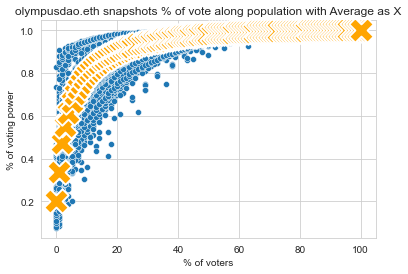

In [109]:
plt.rc("figure", figsize=(40, 20))
sns.set_style("whitegrid")
plt.rc("font", size=25)
data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp","percentage_voters_counted"].agg("mean").reset_index()
##print(data_means)
plot_title = spacename + ' snapshots % of vote along population with Average as X'

ax=sns.scatterplot(data=crunch_data, y="cum_percentage_of_total_vp",x="percentage_voters_counted_stepped").set(title=plot_title,xlabel='% of voters',ylabel='% of voting power')
chart = sns.scatterplot(data=data_means,x="percentage_voters_counted_stepped",y="cum_percentage_of_total_vp",zorder=3, s=600,marker='X',color = 'orange')
#and save the chart file, too
#plt.savefig(final_file+'\\'+spacename+' vote power distribution.png', dpi=100)

#means_data_path =final_file+'\\'+spacename+'_means_'+'.csv'
#data_means.to_csv(means_data_path, index = False)

print(chart)
data_means

The chart above shows what % of all possible votes has been cast (Y axis) as each incremental percent of the voting population casts their vote (X axis). Each line is a Proposal and has a unique color, so that a dot on each percent point represents what % of total voting power was accumulated by that group. The color represents which vote was cast.
The Orange X shows the average % of power accumulated across all elections.

In [110]:
proposal_prices = db.query("Select distinct "
                           "proposal_date::date proposal_date"
                           ",(max(cumulative_usd_value))::decimal proposal_usd_value "
                           "From crunch_data "
                           "where percentage_voters_counted_stepped=50 "
                           "Group by proposal_date"
                           "").df()

proposal_prices.head(10)

,proposal_date,proposal_usd_value
0,2021-04-02,7.411671e+06
1,2021-04-18,2.231735e+07
2,2021-04-29,3.073416e+07
3,2021-05-07,3.090761e+07
4,2021-05-20,1.664023e+07
5,2021-06-03,5.395750e+06
6,2021-06-15,1.337114e+07
7,2021-06-18,1.012697e+07
8,2021-06-30,2.210904e+07
9,2021-07-21,4.921779e+07


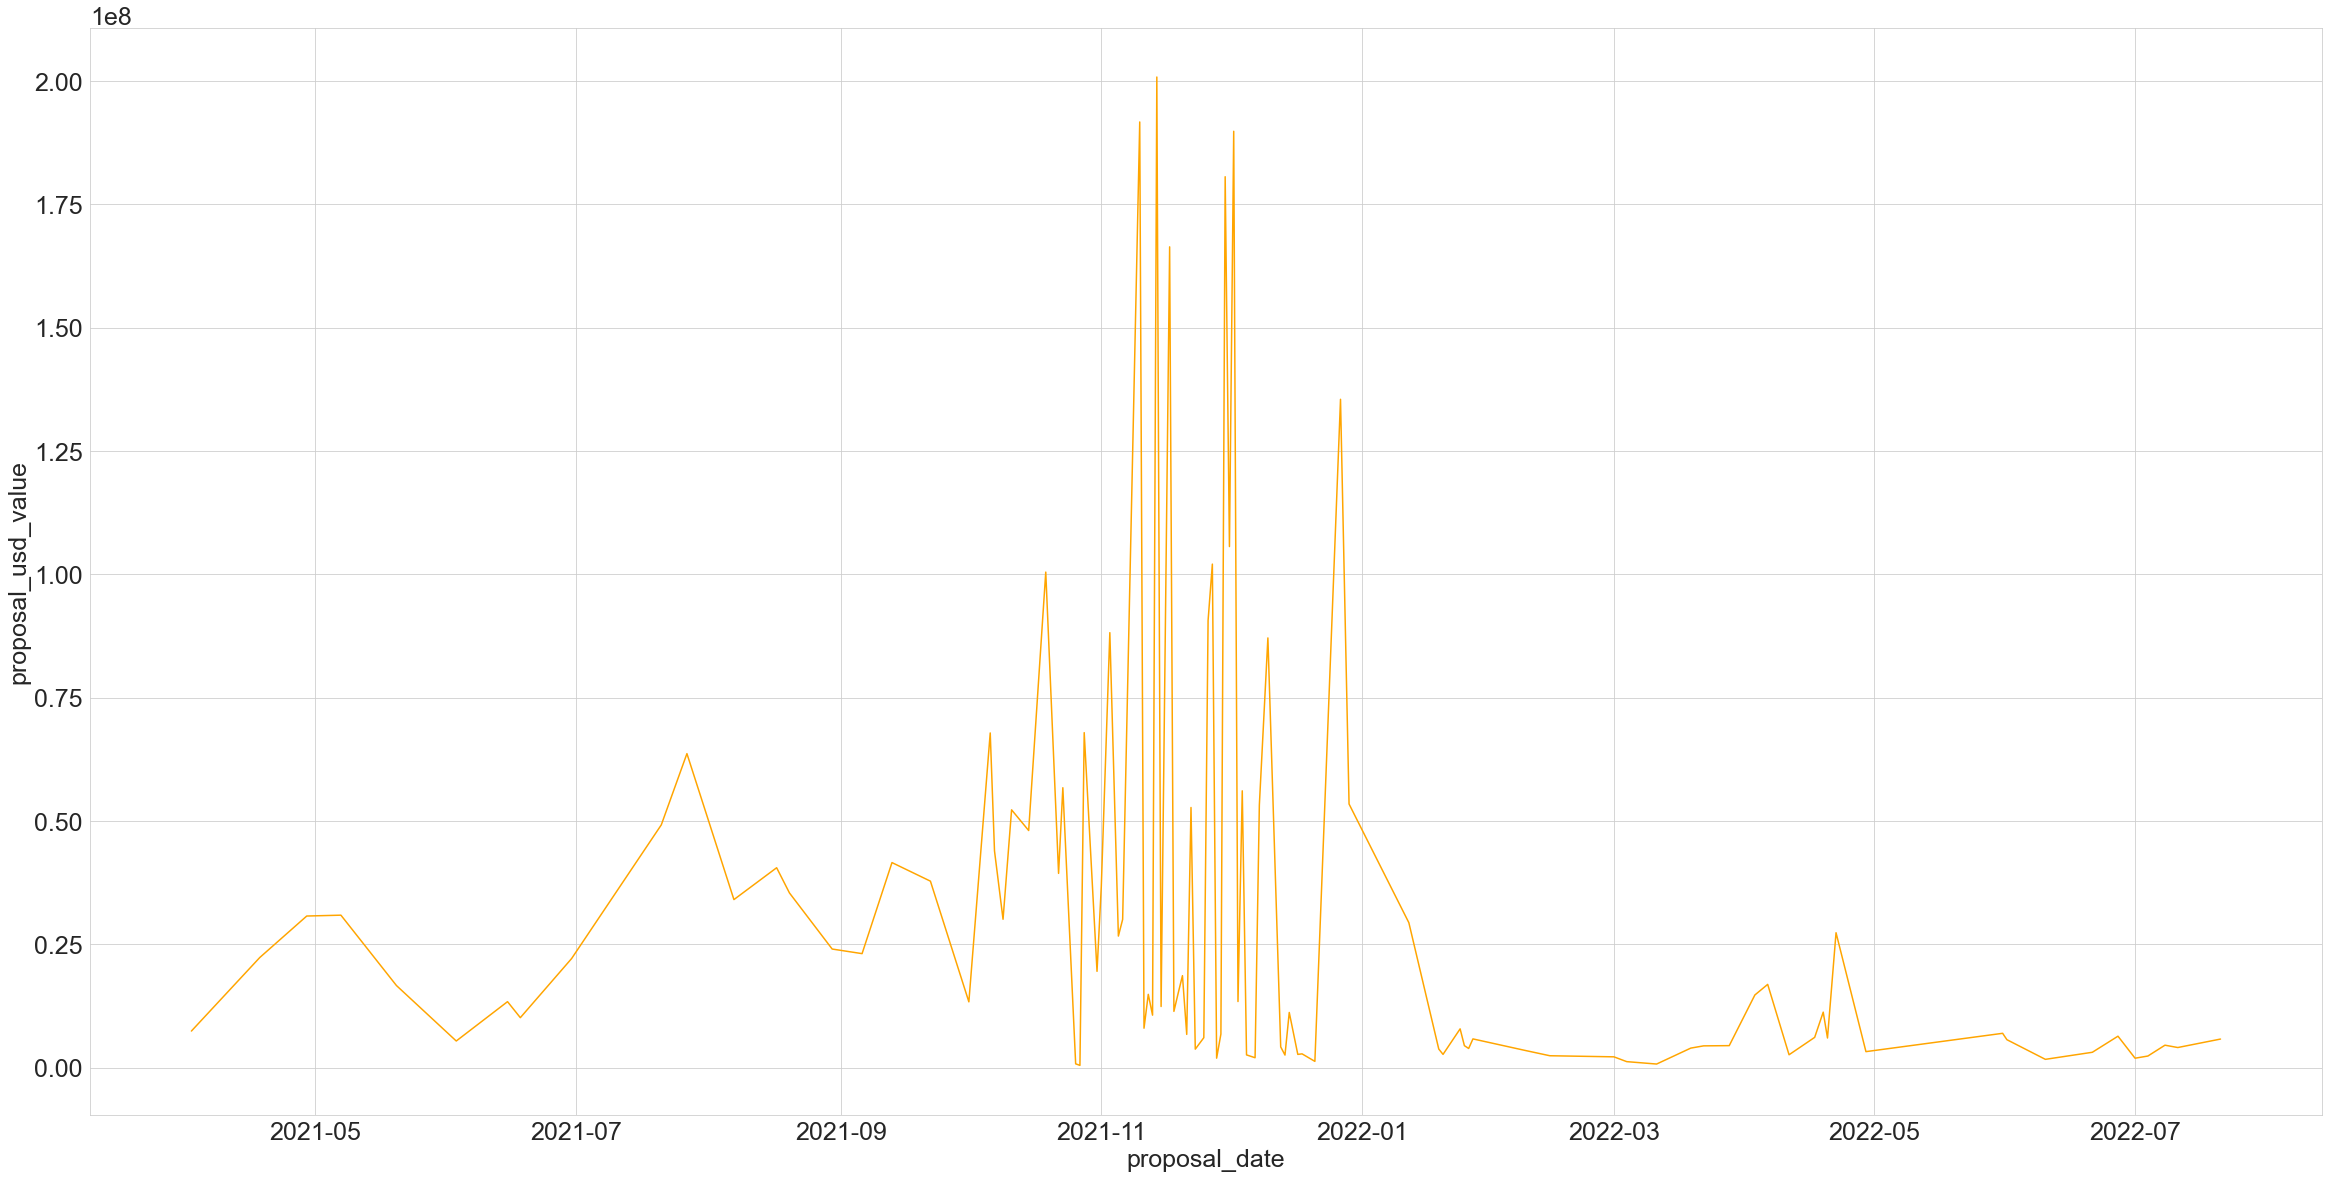

In [111]:
plt.rc("figure", figsize=(40, 20))
sns.set_style("whitegrid")
plt.rc("font", size=25)
chart = sns.lineplot(data=proposal_prices,x="proposal_date",y="proposal_usd_value", color = 'orange')

In [112]:
plt.rc("figure", figsize=(40, 20))
sns.set_style("whitegrid")
plt.rc("font", size=25)
chart = sns.lineplot(data=voters_df,x="proposal_date",y="proposal_usd_value", color = 'orange')

NameError: name 'voters_df' is not defined

AxesSubplot(0.125,0.125;0.775x0.755)


C:\Users\ianfe\PycharmProjects\pythonProject\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ianfe\PycharmProjects\pythonProject\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ianfe\PycharmProjects\pythonProject\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ianfe\PycharmProjects\pythonProject\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ianfe\PycharmProjects\pythonProject\venv\lib\site-packages\IPython\core\pylabtools.

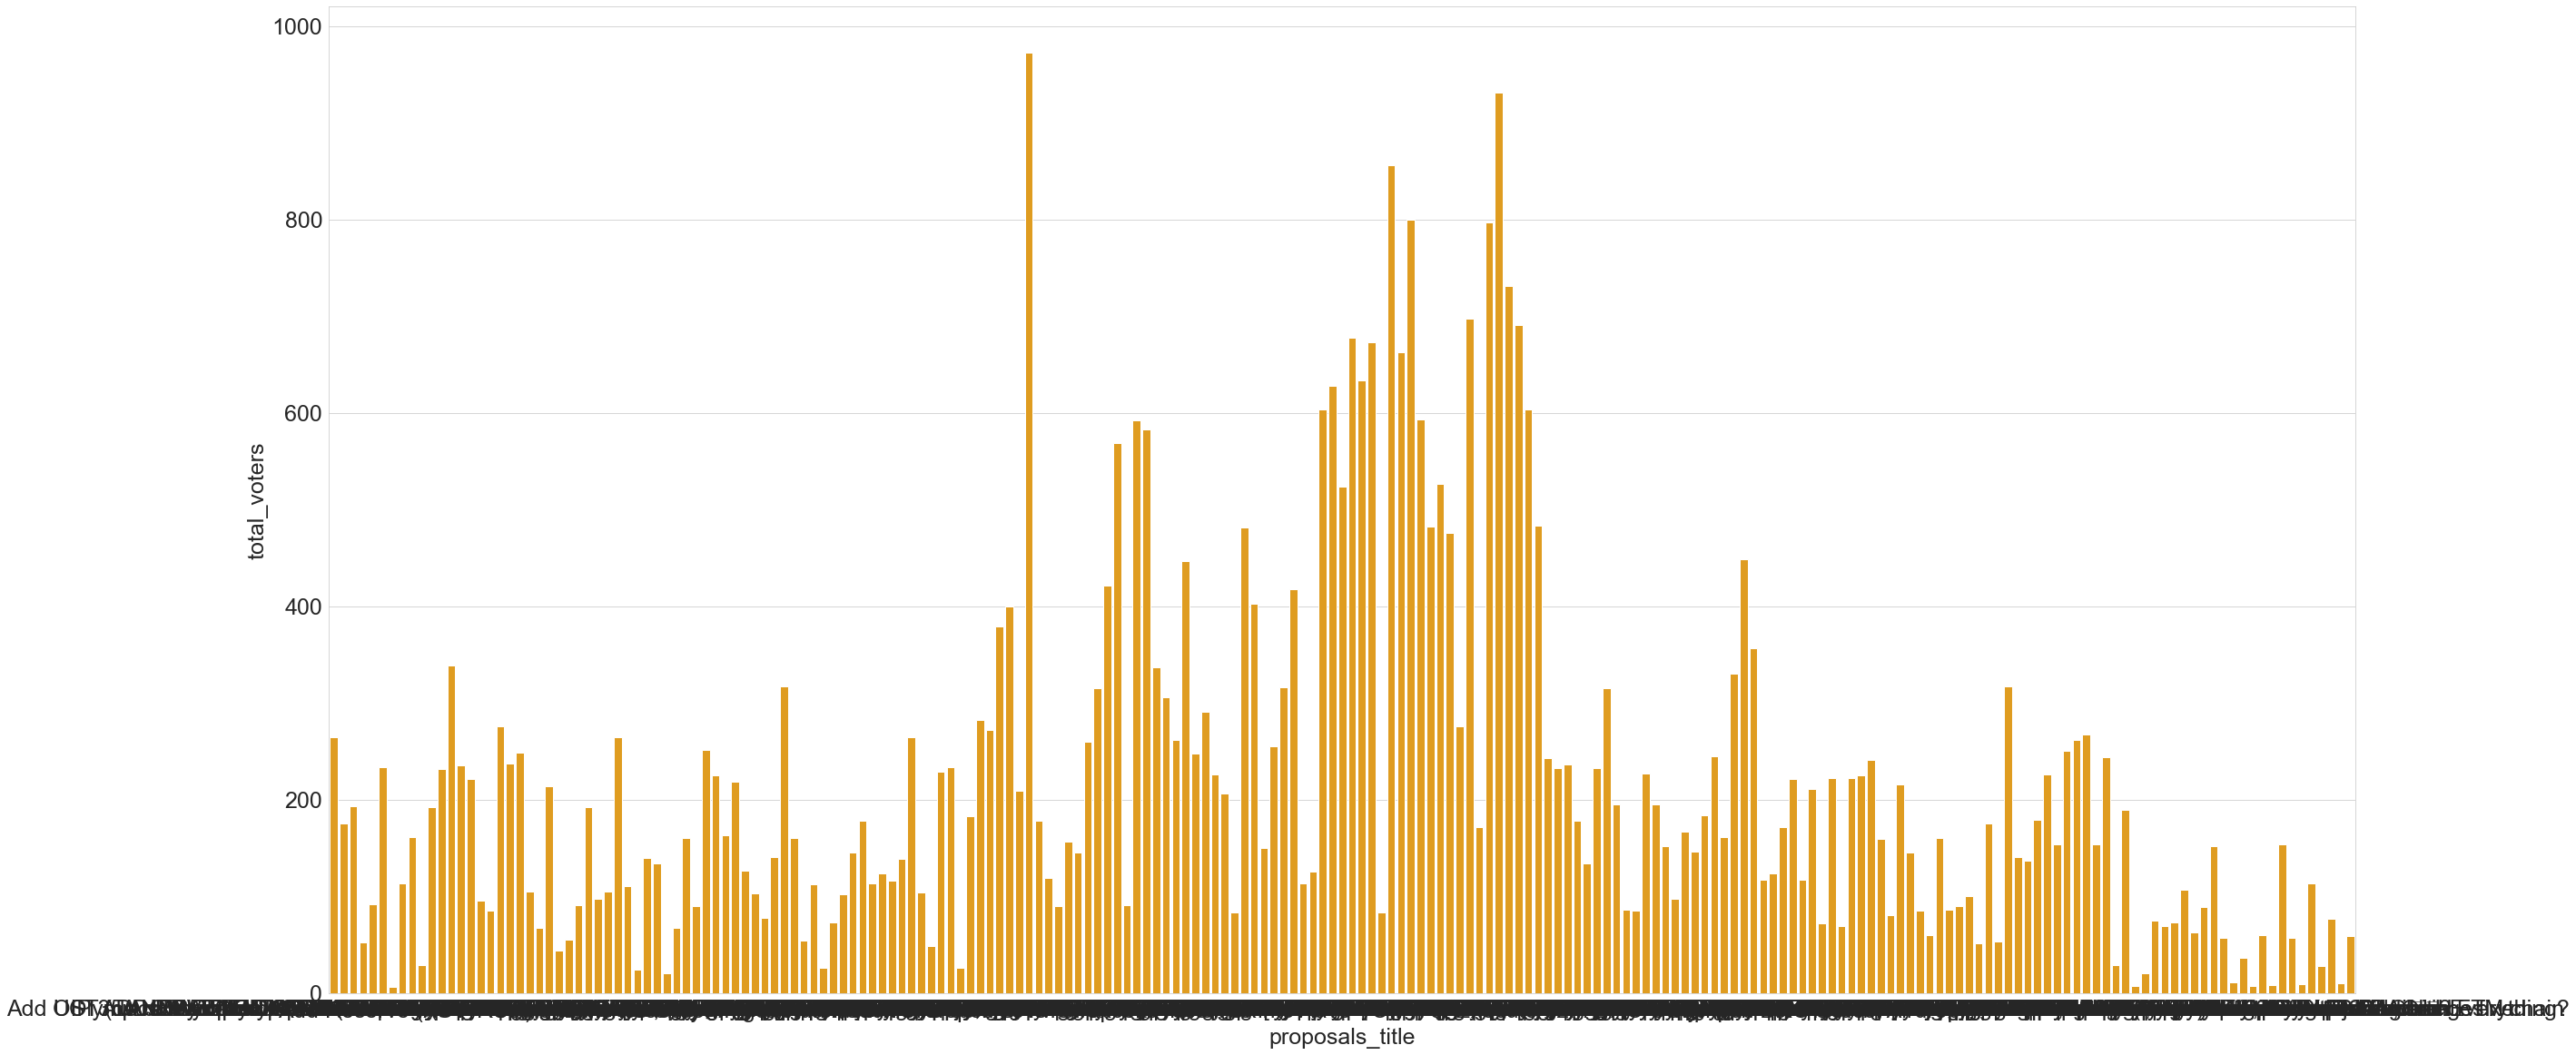

In [113]:
voters_df = db.query("select  proposals_title, count(distinct votes_voter) total_voters,  min(proposal_date) proposal_date from crunch_data group by 1 order by 1 asc").df()

chart = sns.barplot(data=voters_df,x="proposals_title",y="total_voters", color = 'orange')
#and save the chart file, too

print(chart)



AxesSubplot(0.125,0.125;0.775x0.755)


C:\Users\ianfe\PycharmProjects\pythonProject\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ianfe\PycharmProjects\pythonProject\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26085 (\N{CJK UNIFIED IDEOGRAPH-65E5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ianfe\PycharmProjects\pythonProject\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ianfe\PycharmProjects\pythonProject\venv\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 33021 (\N{CJK UNIFIED IDEOGRAPH-80FD}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ianfe\PycharmProjects\pythonProject\venv\lib\site-packages\IPython\core\pylabtools.

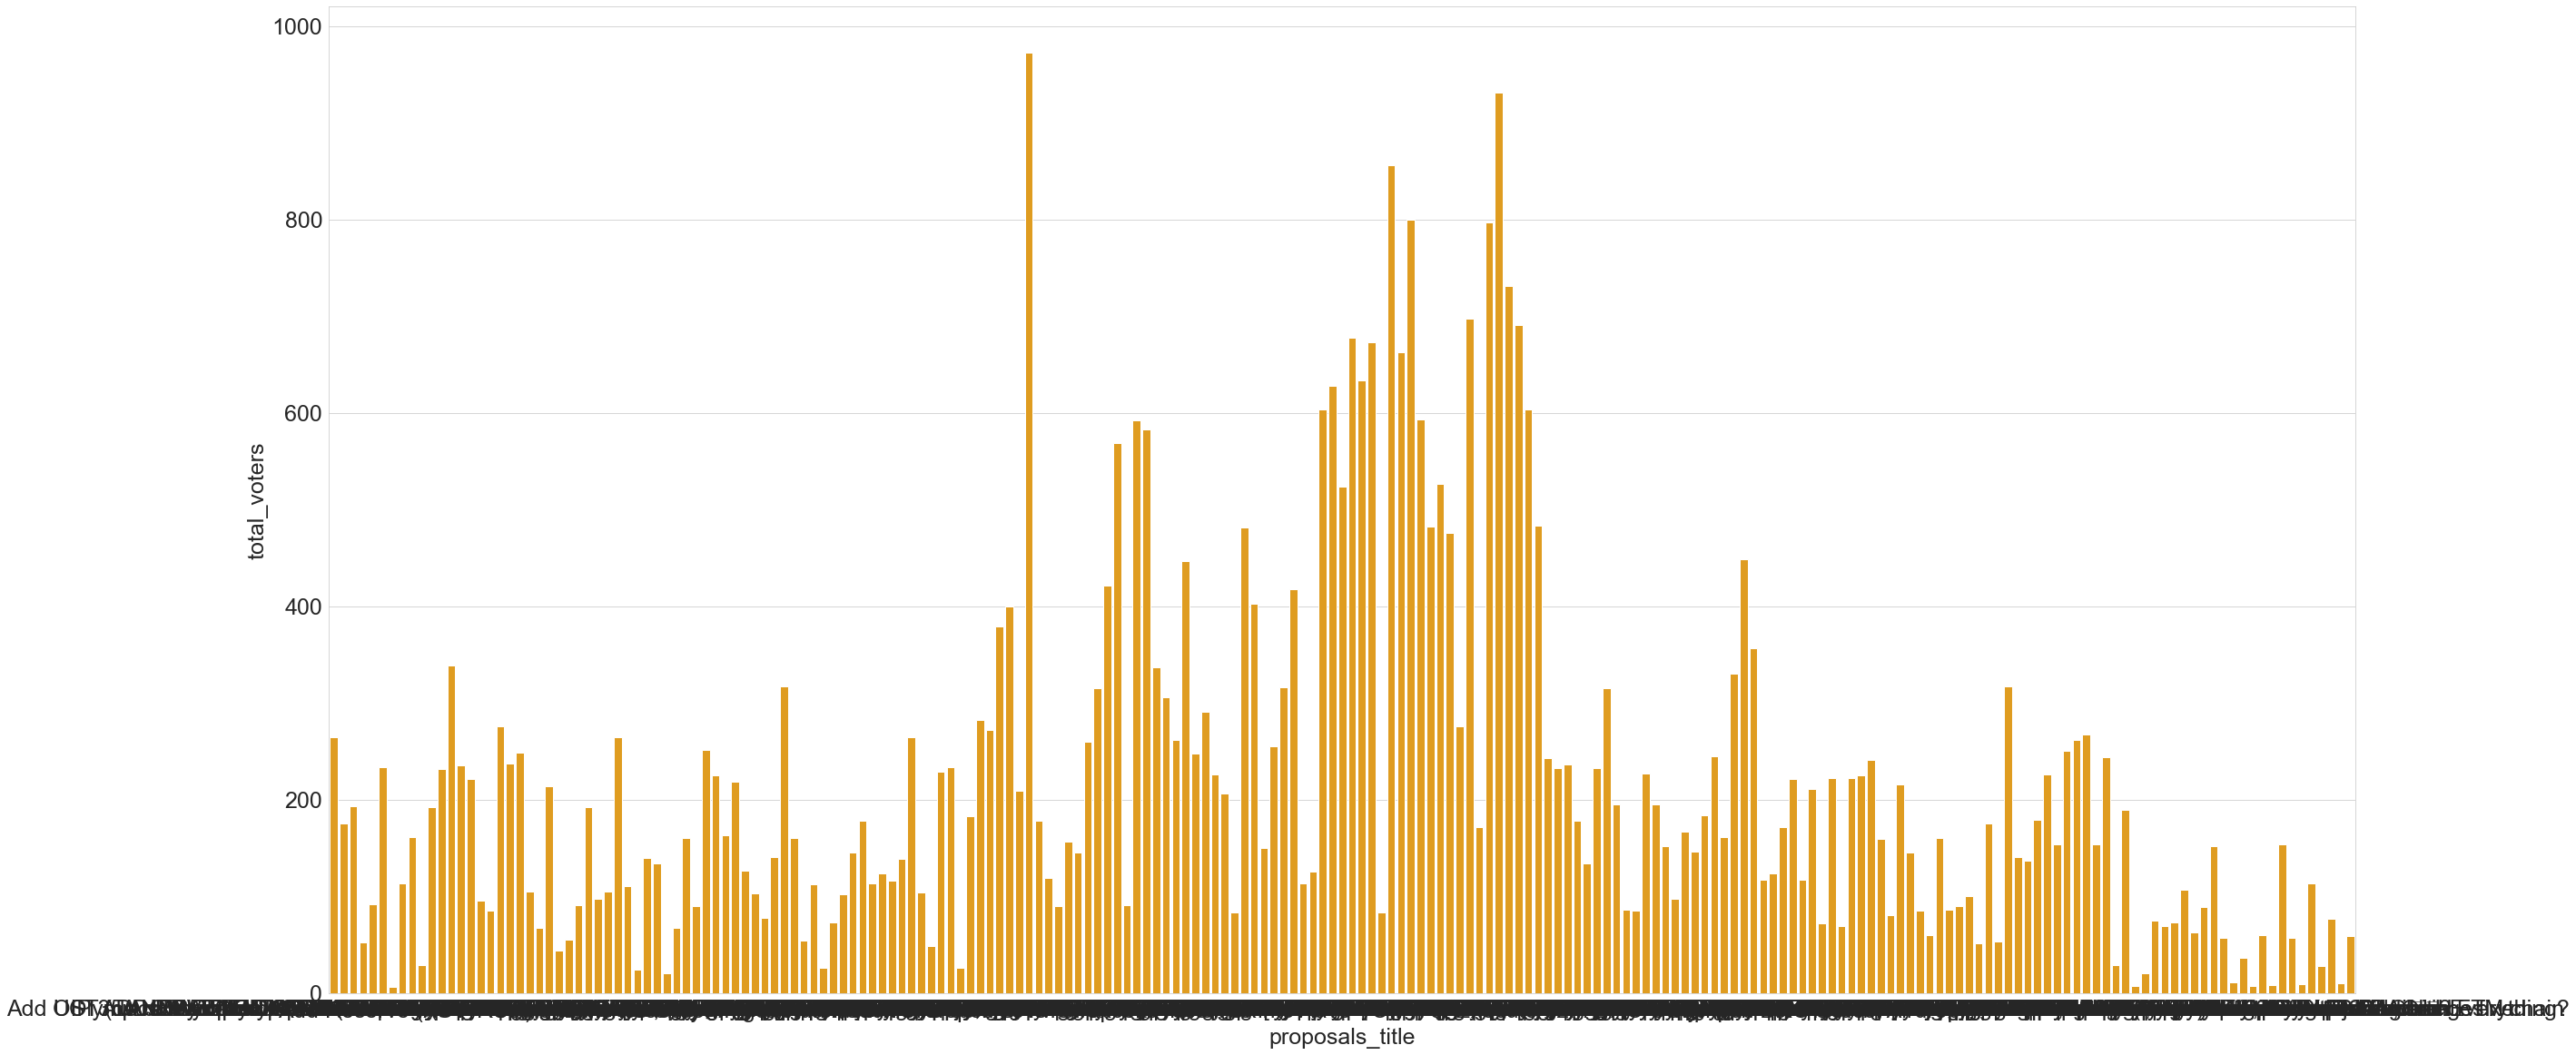

In [114]:
voters_df = db.query("select  proposals_title, count(distinct votes_voter) total_voters,  min(proposal_date) proposal_date from crunch_data group by 1 order by 1 asc").df()

chart = sns.barplot(data=voters_df,x="proposals_title",y="total_voters", color = 'orange')
#and save the chart file, too

print(chart)



In [115]:
p50 = db.query("select min(percentage_voters_counted) "
               "from data_means  where cum_percentage_of_total_vp>=0.5 ").df()
p50display = round(100*(p50.iloc[0,0]),2)
print('On average, a proposal at ', spacename, 'takes ',p50display,'% of the voting population.')

print('A total of ',leader_count, 'wallets have driven the result of all proposals at',spacename,)
print('That\'s', ("{0:.2%}".format(elite)), 'of all DAO voters.')

On average, a proposal at  olympusdao.eth takes  3.0 % of the voting population.
A total of  321 wallets have driven the result of all proposals at olympusdao.eth
That's 3.61% of all DAO voters.
